In [101]:
%matplotlib inline

import pandas as pd
import numpy as np
from utility_functions import report

# sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

import plotly.express as px
import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [102]:
# read dataset
echo_genres = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/datasets & labels [cleaned]/echo_genres.csv')
echo_genres.set_index('track_id', inplace=True)
echo_genres.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
track_id,,,,,,,,,
2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,Pop
134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop


# Binary Classification - Rock & Jazz
## echonest audio features

In [103]:
# select subset of data with genres: Hip Hop or Rock
dataset = echo_genres[echo_genres['genre_top'].isin(['Rock','Jazz'])]
dataset.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
track_id,,,,,,,,,
144,0.909011,0.443643,0.641997,0.924092,0.267669,0.089659,128.537,0.788251,Jazz
145,0.235506,0.438672,0.487752,0.716122,0.070359,0.047298,120.790,0.650452,Jazz
146,0.532019,0.417681,0.476422,0.402500,0.172105,0.035361,135.468,0.682397,Jazz
147,0.778410,0.706681,0.866116,0.806703,0.104650,0.065083,120.218,0.917613,Jazz
153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


In [104]:
# check shape
dataset.shape

(4133, 9)

In [105]:
pd.concat([dataset.genre_top.value_counts(),
                round(dataset.genre_top.value_counts(normalize=True).mul(100),2)],axis=1, keys=('counts','percentage (%)'))

,counts,percentage (%)
Rock,3892,94.17
Jazz,241,5.83


In [106]:
# encoding labels
le = preprocessing.LabelEncoder()
dataset['genre_top'] = le.fit_transform(dataset['genre_top'])
print('legend:\n0: Jazz\n1: Rock')
dataset.genre_top.value_counts()


legend:
0: Jazz
1: Rock


1    3892
0     241
Name: genre_top, dtype: int64

In [107]:
# Define the labels
labels = dataset[['genre_top']]
# labels has as index the id_track, this creates problems when plotting data after the features have been normalized.
# we reset the index from 0 to n
labels.reset_index(drop=True, inplace=True)
labels = labels['genre_top']

In [108]:
dataset.drop('genre_top', axis=1, inplace=True)

In [109]:
# normalize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataset)

# 1. PCA on scaled data
### 1.1 scree-plot
We use PCA to determine by how much we can reduce the dimensionality of our data.
We can use scree-plots and cumulative explained ratio plots to find the number of components to
use in further analysis.
- Screen-plots display the number of components against the variance explained by each component,sorted
in descending order of variance.
The cutoff is determined by the 'elbow' of the screen plot.

Text(0.5, 0, 'Principal Component #')

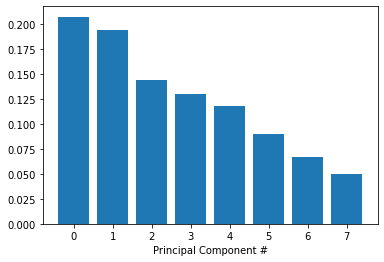

In [110]:
pca = PCA()
pca.fit(scaled_features)
# get explained variance ratios from PCA using all features
exp_variance = pca.explained_variance_ratio_
# plot explained variance
fig, ax= plt.subplots()
ax.bar(range(pca.n_components_),exp_variance)
ax.set_xlabel('Principal Component #')

From the plot we can see that is not straightforward to identify the optimal number of components.
We will determine the optimal number of components by inspecting the cumulative explained
variance plot.

### 1.2 cumulative explained variance plot

Optimal number of components: 6
Explained variation per principal component:
[0.20726979 0.19438099 0.1434904  0.13006163 0.11786647 0.09028045]


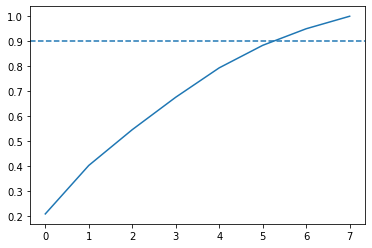

In [149]:
# calculate the cumulative explained variance
cum_exp_var = np.cumsum(exp_variance)

# plot the cumulative explained variance and draw a dashed line at 0.9\
# This line indicates how much variance (information) we want to retain
fig, ax= plt.subplots()
ax.plot(cum_exp_var)
ax.axhline(y=0.9, linestyle='--')

# find index where cum_exp_var exceeds 0.9 and adding 1 to that index to get the num of components
n_components = ((np.where(cum_exp_var > 0.9))[0][0])
print(f"Optimal number of components: {n_components}")
print(f"Explained variation per principal component:\n{pca.explained_variance_ratio_}")
# perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components,random_state=10)
pca.fit(scaled_features)
pca_proj = pca.transform(scaled_features)

### 1.3 plot PCA in 2D

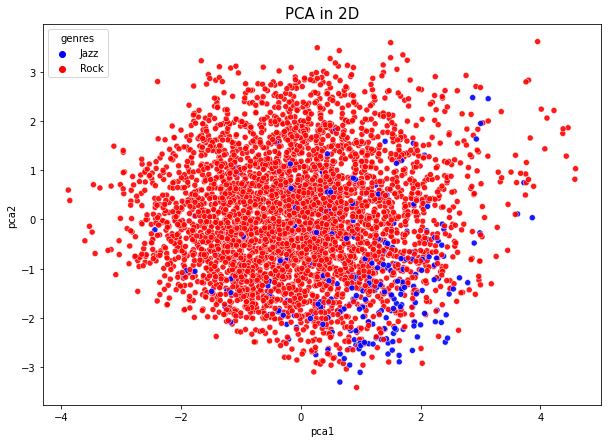

In [112]:
# generating df for plotting PCA
df = pd.DataFrame()
df['pca1'] = pca_proj[:,0]
df['pca2'] = pca_proj[:,1]
df['pca3'] = pca_proj[:,2]
df['genres'] = labels.apply(lambda x: "Rock" if x==1 else "Jazz")

# plot scatter of PCA
plt.figure(figsize=(10,7))
sns.scatterplot(
    x="pca1", y="pca2",
    hue='genres',
    palette={'Jazz':'blue','Rock':'red'},
    data=df,
    legend="full",
    alpha=0.9
)
plt.title("PCA in 2D", fontsize= 15)
plt.show()

# 1.4 plot PCA in 3D

In [113]:
# 3D PCA
#total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    df, x='pca1', y='pca2', z='pca3', color='genres',
    #title=f'Total Explained Variance: {total_var:.2f}%',
    #labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.update_layout(legend=dict(
    orientation="v",
    yanchor="bottom",
    y=1,
    xanchor="right",
    x=0.6
))
fig.show()

# 2. Model selection

In [114]:
# shuffle and split into development set and internal test set:
# (PCA)
Xpca_develop, Xpca_test, y_develop_pca, y_test_pca = train_test_split(
pca_proj, labels, test_size=0.30, random_state=42, stratify=labels)

# (no PCA)
X_develop, X_test, y_develop, y_test = train_test_split(
scaled_features, labels, test_size=0.30, random_state=42,stratify= labels)

In [115]:
# check partition
print(f"____Legend____\n1: Rock\n0: Jazz\n\n***PCA***\nDevelopment set:\
\n{y_develop_pca.value_counts()}\n\nInternal Test:\n{y_test_pca.value_counts()}\n\n\
-----------------\n\
***No-PCA***\nDevelopment set:\n{y_develop.value_counts()}\n\nInternal Test:\n{y_test.value_counts()}")

____Legend____
1: Rock
0: Jazz

***PCA***
Development set:
1    2724
0     169
Name: genre_top, dtype: int64

Internal Test:
1    1168
0      72
Name: genre_top, dtype: int64

-----------------
***No-PCA***
Development set:
1    2724
0     169
Name: genre_top, dtype: int64

Internal Test:
1    1168
0      72
Name: genre_top, dtype: int64


# 2.1 Decision Tree -  Unbalanced - without PCA

### 2.1.1 10 fold cross validation - grid search

In [116]:
param_grid = {
               "max_depth": [2,3,4,5,6,7,8,9,10, None],
               "min_samples_leaf": [25,35,45,55,75,100,150,250,300,None],
               "criterion": ["gini", "entropy"]
             }
# model
dtc = DecisionTreeClassifier()
stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
random_search = GridSearchCV(dtc, cv =stratified_cv , param_grid=param_grid, n_jobs=2, verbose=True)

random_search.fit(X_develop, y_develop)
dtc=random_search.best_estimator_
report(random_search.cv_results_, n_top=3)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Model with rank: 1
Mean validation score: 0.943 (std: 0.007)
Parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.943 (std: 0.007)
Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.943 (std: 0.007)
Parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.943 (std: 0.007)
Parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.943 (std: 0.007)
Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 35}

Model with rank: 1
Mean validation score: 0.943 (std: 0.007)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 35}



### 2.1.2 5 fold cross validation - grid search

In [117]:
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = GridSearchCV(dtc, cv =stratified_cv , param_grid=param_grid, n_jobs=2, verbose=True)

random_search.fit(X_develop, y_develop)
dtc=random_search.best_estimator_
report(random_search.cv_results_, n_top=3)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Model with rank: 1
Mean validation score: 0.942 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 25}

Model with rank: 1
Mean validation score: 0.942 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 25}

Model with rank: 1
Mean validation score: 0.942 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 25}

Model with rank: 1
Mean validation score: 0.942 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 25}

Model with rank: 1
Mean validation score: 0.942 (std: 0.006)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 25}



### 2.1.3 Retrain on full development set and prediction

Accuracy 0.9314516129032258
F1-score [0.32       0.96390658]
              precision    recall  f1-score   support

           0       0.38      0.28      0.32        72
           1       0.96      0.97      0.96      1168

    accuracy                           0.93      1240
   macro avg       0.67      0.62      0.64      1240
weighted avg       0.92      0.93      0.93      1240



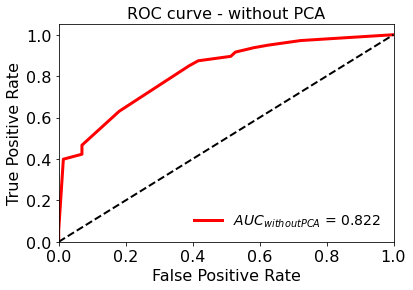

In [135]:
dtc = DecisionTreeClassifier(criterion= 'entropy',max_depth=6, min_samples_leaf= 35)
dtc.fit(X_develop,y_develop)

y_pred_dtc = dtc.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred_dtc))
print('F1-score %s' % f1_score(y_test, y_pred_dtc, average=None))
print(classification_report(y_test, y_pred_dtc))

# y_score0 --> scores of decision tree without PCA
# fpr0, tpr0 ---> false positive and true positive of decision tree without PCA
y_score0 = dtc.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score0[:, 1])

# roc_auc0 --> ROC/AUC of decision tree without PCA
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='red', lw=3, label='$AUC_{without PCA}$ = %.3f' % roc_auc0)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve - without PCA', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Legend:
0: Jazz
1: Rock
[[  20   52]
 [  33 1135]]


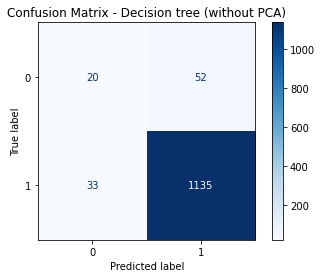

In [136]:
# confusion matrix - Internal Test
print("Legend:\n0: Jazz"
      "\n1: Rock")
cm = plot_confusion_matrix(dtc,X_test,y_test,
                            cmap = plt.cm.Blues)
cm.ax_.set_title('Confusion Matrix - Decision tree (without PCA)')
print(cm.confusion_matrix)
plt.show()

# 2.2 Decision Tree -  Unbalanced - with PCA
### 2.2.1 10 fold cross validation - grid search

In [120]:
# model
dtc_pca = DecisionTreeClassifier()
stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
random_search_pca = GridSearchCV(dtc, cv =stratified_cv , param_grid=param_grid, n_jobs=2, verbose=True)

random_search_pca.fit(Xpca_develop, y_develop_pca)
dtc_pca=random_search_pca.best_estimator_
report(random_search_pca.cv_results_, n_top=10)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Model with rank: 1
Mean validation score: 0.946 (std: 0.010)
Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 35}

Model with rank: 2
Mean validation score: 0.946 (std: 0.010)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 25}

Model with rank: 2
Mean validation score: 0.946 (std: 0.010)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 35}

Model with rank: 2
Mean validation score: 0.946 (std: 0.010)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 45}

Model with rank: 2
Mean validation score: 0.946 (std: 0.010)
Parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 45}

Model with rank: 2
Mean validation score: 0.946 (std: 0.010)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 45}

Model with rank: 2
Mean validation score: 0.946 (std: 0.010)
Parameters: {'criterion': 'entropy', 'max_d

### 2.2.2 5 fold cross validation - grid search

In [121]:
dtc_pca = DecisionTreeClassifier()
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search_pca = GridSearchCV(dtc, cv =stratified_cv , param_grid=param_grid, n_jobs=2, verbose=True)

random_search_pca.fit(Xpca_develop, y_develop_pca)
dtc_pca=random_search_pca.best_estimator_
report(random_search_pca.cv_results_, n_top=10)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Model with rank: 1
Mean validation score: 0.945 (std: 0.003)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 25}

Model with rank: 1
Mean validation score: 0.945 (std: 0.003)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 35}

Model with rank: 3
Mean validation score: 0.943 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 35}

Model with rank: 4
Mean validation score: 0.943 (std: 0.002)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 45}

Model with rank: 5
Mean validation score: 0.942 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 25}

Model with rank: 5
Mean validation score: 0.942 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 25}

Model with rank: 5
Mean validation score: 0.942 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': 6, 

### 2.2.3 Retrain on full development set and prediction

Accuracy 0.9338709677419355
F1-score [0.24074074 0.96543002]
              precision    recall  f1-score   support

           0       0.36      0.18      0.24        72
           1       0.95      0.98      0.97      1168

    accuracy                           0.93      1240
   macro avg       0.66      0.58      0.60      1240
weighted avg       0.92      0.93      0.92      1240



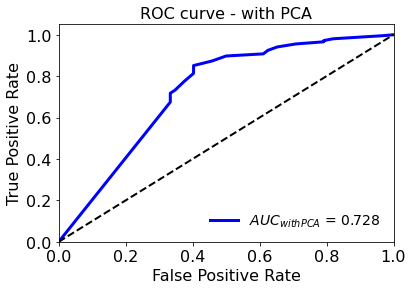

In [139]:
dtc_pca = DecisionTreeClassifier(criterion= 'gini',max_depth=3, min_samples_leaf= 35)
dtc_pca.fit(Xpca_develop,y_develop_pca)

y_pred_dtc_pca = dtc_pca.predict(Xpca_test)

print('Accuracy %s' % accuracy_score(y_test_pca, y_pred_dtc_pca))
print('F1-score %s' % f1_score(y_test_pca, y_pred_dtc_pca, average=None))
print(classification_report(y_test_pca, y_pred_dtc_pca))

# y_score1 --> scores of decision tree with PCA
# fpr1, tpr1 ---> false positive and true positive of decision tree with PCA
y_score1 = dtc_pca.predict_proba(Xpca_test)
fpr1, tpr1, _ = roc_curve(y_test_pca, y_score1[:, 1])

# roc_auc1 --> ROC/AUC of decision tree with PCA
roc_auc1 = auc(fpr1, tpr1)

plt.plot(fpr1, tpr1, color='blue', lw=3, label='$AUC_{with PCA}$ = %.3f' % roc_auc1)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve - with PCA', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Legend:
0: Jazz
1: Rock
[[  13   59]
 [  23 1145]]


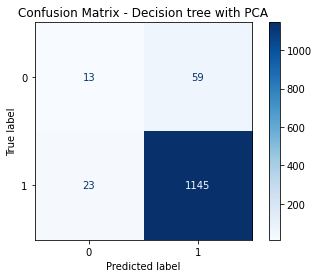

In [138]:
# confusion matrix Decision tree with PCA
print("Legend:\n0: Jazz\n1: Rock")
cm_pca = plot_confusion_matrix(dtc_pca,Xpca_test,y_test_pca,
                            cmap = plt.cm.Blues)
cm_pca.ax_.set_title('Confusion Matrix - Decision tree with PCA')
print(cm_pca.confusion_matrix)
plt.show()

# 2.3 Comparing ROC Decision tree (unbalanced) with and without PCA

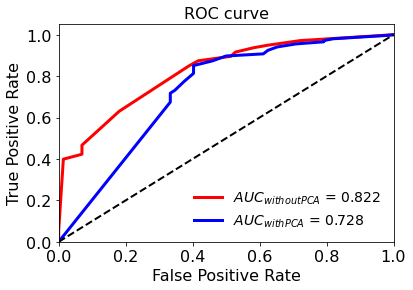

In [140]:
plt.plot(fpr0, tpr0, color='red', lw=3, label='$AUC_{without PCA}$ = %.3f' % roc_auc0)
plt.plot(fpr1, tpr1, color='blue', lw=3, label='$AUC_{with PCA}$ = %.3f' % roc_auc1)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# 3.1 KNN binary class - Unbalanced (without PCA)

### 3.1.1 10 fold cross validation - grid search

In [125]:
# range of k to try - find a good range of k
k_range = range(1, 250)
# empty list to store scores
k_scores = []

for k in tqdm(k_range):
    # run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k)
    # obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn, X_develop, y_develop, cv=10, scoring='accuracy')
    # append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())

print(k_scores)
print(f"maximum score: {max(k_scores)} for k = {k_scores.index(max(k_scores))+1}")

100%|██████████| 249/249 [02:04<00:00,  2.01it/s]


[0.9205023266913257, 0.8963071232549815, 0.9346677007517004, 0.932592769359265, 0.9439983295549457, 0.9405417014676054, 0.9474573439923638, 0.9440019090800622, 0.9460756472974585, 0.9453812194248897, 0.9453836057749673, 0.9446903710774371, 0.9446927574275147, 0.946073260947381, 0.9460732609473809, 0.9453824125999285, 0.9453836057749673, 0.9460756472974584, 0.9436582746688937, 0.9457320128862904, 0.9433110607326093, 0.9436582746688937, 0.9440007159050232, 0.9446903710774371, 0.9436546951437776, 0.9433086743825321, 0.9429626536212862, 0.9439983295549457, 0.9436535019687387, 0.9450363918386827, 0.9446903710774371, 0.9450375850137217, 0.9446915642524758, 0.9453824125999283, 0.9453812194248897, 0.9453812194248897, 0.9450375850137214, 0.9457272401861353, 0.944001909080062, 0.9440031022551008, 0.9429650399713637, 0.9436558883188162, 0.9433110607326096, 0.9433110607326096, 0.9433122539076482, 0.9429662331464026, 0.9433110607326096, 0.9433110607326096, 0.9433122539076482, 0.9436570814938552, 0.

Text(0, 0.5, 'Cross-validated accuracy')

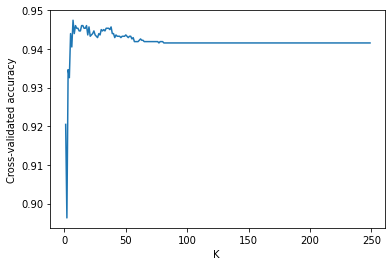

In [126]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('K ')
plt.ylabel('Cross-validated accuracy')

## 3.1.2 Prediction on Internal test set (KNN - without PCA)

In [127]:
X_test.shape, y_test.shape

((1240, 8), (1240,))

              precision    recall  f1-score   support

           0       0.40      0.14      0.21        72
           1       0.95      0.99      0.97      1168

    accuracy                           0.94      1240
   macro avg       0.67      0.56      0.59      1240
weighted avg       0.92      0.94      0.92      1240

legend:
0: Jazz
1: Rock


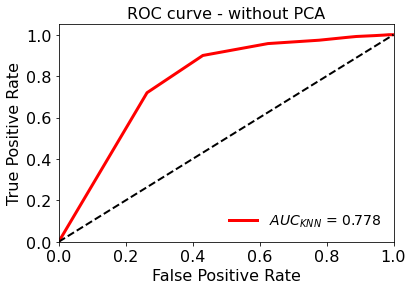

In [141]:
knn_classifier =  KNeighborsClassifier(n_neighbors = 7)

# retrain knn on the whole development set
knn_classifier.fit(X_develop, y_develop)
# predict target variable
y_pred_knn0 = knn_classifier.predict(X_test)
# display classification report
print(classification_report(y_test, y_pred_knn0))
print('legend:\n0: Jazz\n1: Rock')

# plot ROC curve -KNN
y_score_knn0 = knn_classifier.predict_proba(X_test)
fpr_knn0, tpr_knn0, _ = roc_curve(y_test, y_score_knn0[:, 1])
roc_auc_knn0 = auc(fpr_knn0, tpr_knn0)

plt.plot(fpr_knn0, tpr_knn0, color='red', lw=3, label='$AUC_{KNN}$ = %.3f' % roc_auc_knn0)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve - without PCA', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Legend:
0: Jazz
1: Rock
[[  10   62]
 [  15 1153]]


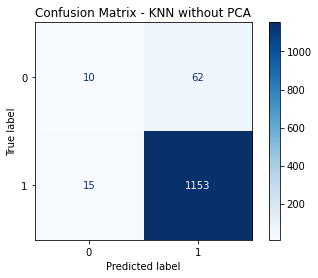

In [142]:
# confusion matrix KNN - Internal test
print("Legend:\n0: Jazz\n1: Rock")
cm_knn = plot_confusion_matrix(knn_classifier,X_test,y_test,
                            cmap = plt.cm.Blues)
cm_knn.ax_.set_title('Confusion Matrix - KNN without PCA')
print(cm_knn.confusion_matrix)
plt.show()

# 3.2 KNN binary class - Unbalanced (with PCA)
### 3.2.1 10 fold cross validation - grid search

In [130]:
# range of k to try - find a good range of k
k_range = range(1, 250)
# empty list to store scores
k_scores = []

for k in tqdm(k_range):
    # run KNeighborsClassifier with k neighbours
    knn_pca = KNeighborsClassifier(n_neighbors=k)
    # obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn_pca, Xpca_develop, y_develop_pca, cv=10, scoring='accuracy')
    # append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())

print(k_scores)
print(f"maximum score: {max(k_scores)} for k = {k_scores.index(max(k_scores))+1}")

100%|██████████| 249/249 [01:32<00:00,  2.71it/s]


[0.9153108220976017, 0.8935377639899773, 0.9336308316430021, 0.9294833552082091, 0.9412361293401743, 0.9353585490991527, 0.9429662331464026, 0.9419341367378596, 0.9440042954301398, 0.9433146402577257, 0.9446963369526309, 0.9450411645388378, 0.9460792268225748, 0.9453883784751224, 0.9433122539076482, 0.9436570814938552, 0.9436558883188162, 0.9436546951437776, 0.9450351986636442, 0.9453824125999285, 0.9453824125999285, 0.9464204748836653, 0.9450375850137217, 0.9450375850137217, 0.9436523087936999, 0.9443443503161915, 0.9429626536212863, 0.9429638467963251, 0.9422718052738336, 0.9422718052738336, 0.9429626536212863, 0.9426178260350794, 0.9426154396850018, 0.9426154396850018, 0.9422718052738336, 0.9422706120987948, 0.9429626536212863, 0.9422718052738336, 0.9440007159050232, 0.9446915642524758, 0.9440007159050232, 0.9436558883188162, 0.944346736666269, 0.9436558883188162, 0.9443479298413078, 0.9450387781887605, 0.9446915642524758, 0.945383605774967, 0.9443467366662688, 0.9446927574275146, 0

Text(0, 0.5, 'Cross-validated accuracy')

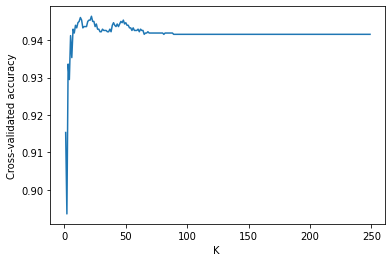

In [131]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('K ')
plt.ylabel('Cross-validated accuracy')

## 3.1.2 Prediction on Internal test set (KNN - with PCA)

              precision    recall  f1-score   support

           0       0.46      0.15      0.23        72
           1       0.95      0.99      0.97      1168

    accuracy                           0.94      1240
   macro avg       0.70      0.57      0.60      1240
weighted avg       0.92      0.94      0.93      1240

legend:
0: Jazz
1: Rock


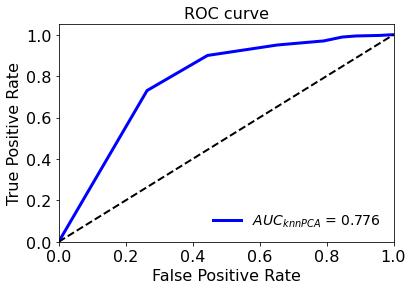

In [152]:
knn_classifier_pca =  KNeighborsClassifier(n_neighbors = 22)

# retrain knn on the whole development set
knn_classifier_pca.fit(Xpca_develop, y_develop_pca)
# predict target variable
y_pred_knn1 = knn_classifier_pca.predict(Xpca_test)
# display classification report
print(classification_report(y_test_pca, y_pred_knn1))
print('legend:\n0: Jazz\n1: Rock')

# plot ROC curve -KNN
y_score_knn1 = knn_classifier_pca.predict_proba(Xpca_test)
fpr_knn1, tpr_knn1, _ = roc_curve(y_test_pca, y_score_knn1[:, 1])
roc_auc_knn1 = auc(fpr_knn1, tpr_knn1)

plt.plot(fpr_knn1, tpr_knn1, color='blue', lw=3, label='$AUC_{knnPCA}$ = %.3f' % roc_auc_knn1)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Legend:
0: Jazz
1: Rock
[[  11   61]
 [  13 1155]]


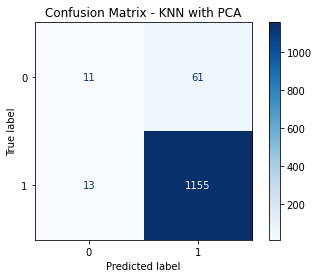

In [146]:
# confusion matrix KNN - Internal test
print("Legend:\n0: Jazz\n1: Rock")
cm_knn_pca = plot_confusion_matrix(knn_classifier_pca,Xpca_test,y_test_pca,
                            cmap = plt.cm.Blues)
cm_knn_pca.ax_.set_title('Confusion Matrix - KNN with PCA')
print(cm_knn_pca.confusion_matrix)
plt.show()

# Compare KNN ROC with and without PCA

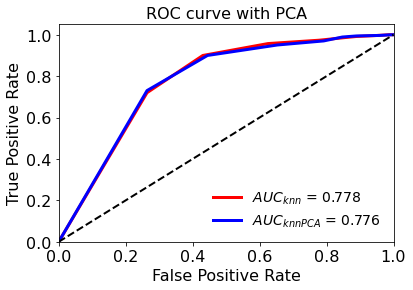

In [148]:
plt.plot(fpr_knn0, tpr_knn0, color='red', lw=3, label='$AUC_{knn}$ = %.3f' % roc_auc_knn0)
plt.plot(fpr_knn1, tpr_knn1, color='blue', lw=3, label='$AUC_{knnPCA}$ = %.3f' % roc_auc_knn1)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve with PCA', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Compare Decision tree and KNN (best scores)

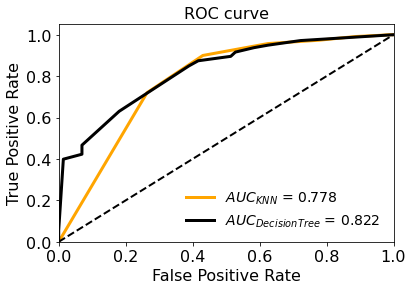

In [147]:
plt.plot(fpr_knn0, tpr_knn0, color='orange', lw=3, label='$AUC_{KNN}$ = %.3f' % roc_auc_knn0)
plt.plot(fpr0, tpr0, color='black', lw=3, label='$AUC_{DecisionTree}$ = %.3f' % roc_auc0)

plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()